# 03 - Driver Delta & Consistency (Fuel-Neutral)

## Objective
Compare teammate performance under matched compound conditions
using fuel-corrected lap times to isolate intrinsic driver pace.

In [184]:
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.config import RACE_YEAR, RACE_NAME

In [186]:
laps = pd.read_csv(
    f"../data/processed/{RACE_YEAR}_{RACE_NAME}_fuel_corrected.csv"
)

laps.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Sector1Sec,Sector2Sec,Sector3Sec,FuelProxy,StintLap,Warmup,SafetyCar,StintLap_c,FuelProxy_c,FullyCorrectedLap
0,0 days 01:05:53.876000,VER,1,0 days 00:01:37.974000,2.0,1.0,NaN,NaN,0 days 00:00:31.342000,0 days 00:00:42.504000,...,31.342,42.504,24.128,55.0,0,1,0,-7.241794,26.449672,96.192236
1,0 days 01:07:31.882000,VER,1,0 days 00:01:38.006000,3.0,1.0,NaN,NaN,0 days 00:00:31.388000,0 days 00:00:42.469000,...,31.388,42.469,24.149,54.0,1,1,0,-6.241794,25.449672,96.299644
2,0 days 01:09:09.858000,VER,1,0 days 00:01:37.976000,4.0,1.0,NaN,NaN,0 days 00:00:31.271000,0 days 00:00:42.642000,...,31.271,42.642,24.063,53.0,2,1,0,-5.241794,24.449672,96.345051
3,0 days 01:10:47.893000,VER,1,0 days 00:01:38.035000,5.0,1.0,NaN,NaN,0 days 00:00:31.244000,0 days 00:00:42.724000,...,31.244,42.724,24.067,52.0,3,0,0,-4.241794,23.449672,96.266720
4,0 days 01:12:25.879000,VER,1,0 days 00:01:37.986000,6.0,1.0,NaN,NaN,0 days 00:00:31.341000,0 days 00:00:42.632000,...,31.341,42.632,24.013,51.0,4,0,0,-3.241794,22.449672,96.293128


In [188]:
driver1 = "HAM"
driver2 = "RUS"

d1 = laps[laps["Driver"] == driver1].copy()
d2 = laps[laps["Driver"] == driver2].copy()

In [192]:
merged = d1.merge(
    d2,
    on=["LapNumber", "Compound"],
    suffixes=("_D1", "_D2")
)

# Remove Safety Car laps
merged = merged[merged["SafetyCar_D1"] == 0]

In [196]:
merged["Delta"] = (
    merged["FullyCorrectedLap_D1"] -
    merged["FullyCorrectedLap_D2"]
)

merged["Delta"].describe()

count    48.000000
mean      0.035907
std       0.440040
min      -1.061000
25%      -0.246250
50%       0.024000
75%       0.263000
max       1.085000
Name: Delta, dtype: float64

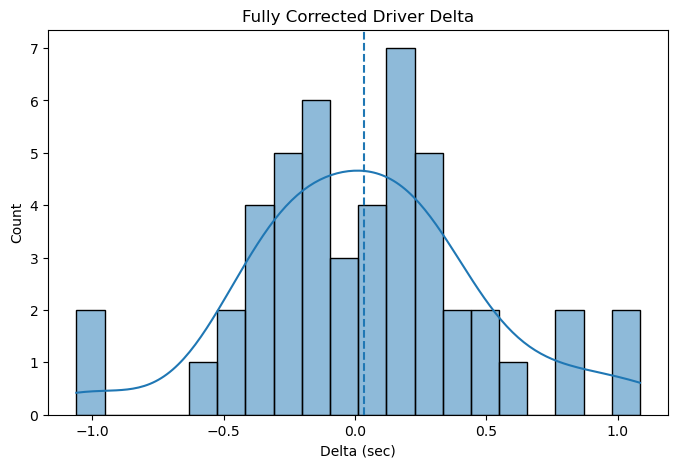

In [198]:
plt.figure(figsize=(8,5))
sns.histplot(merged["Delta"], bins=20, kde=True)
plt.axvline(merged["Delta"].mean(), linestyle="--")
plt.title("Fully Corrected Driver Delta")
plt.xlabel("Delta (sec)")
plt.show()

In [200]:
consistency_d1 = (
    d1[d1["SafetyCar"] == 0]
    .groupby("Stint")["FullyCorrectedLap"]
    .std()
    .mean()
)

consistency_d2 = (
    d2[d2["SafetyCar"] == 0]
    .groupby("Stint")["FullyCorrectedLap"]
    .std()
    .mean()
)

print(driver1, round(consistency_d1,4))
print(driver2, round(consistency_d2,4))

HAM 0.6228
RUS 0.6997


In [202]:
merged.loc[:, "Sector1Delta"] = (
    merged["Sector1Sec_D1"] -
    merged["Sector1Sec_D2"]
)

merged.loc[:, "Sector2Delta"] = (
    merged["Sector2Sec_D1"] -
    merged["Sector2Sec_D2"]
)

merged.loc[:, "Sector3Delta"] = (
    merged["Sector3Sec_D1"] -
    merged["Sector3Sec_D2"]
)

sector_means = {
    "Sector1": merged["Sector1Delta"].mean(),
    "Sector2": merged["Sector2Delta"].mean(),
    "Sector3": merged["Sector3Delta"].mean()
}

sector_means

{'Sector1': 0.00950000000000036,
 'Sector2': 0.006895833333332509,
 'Sector3': 0.02837500000000004}

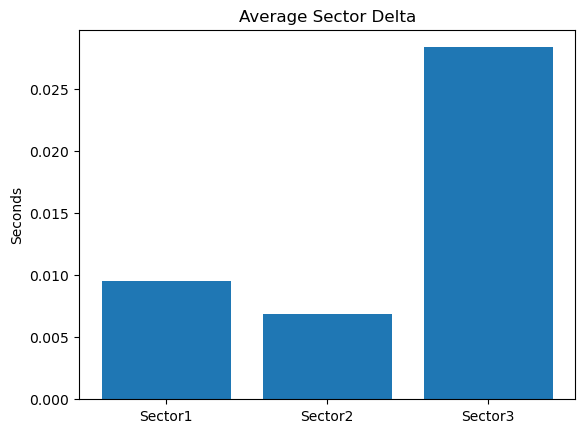

In [204]:
plt.bar(sector_means.keys(), sector_means.values())
plt.title("Average Sector Delta")
plt.ylabel("Seconds")
plt.show()

## Interpretation

- Fuel-neutral lap delta isolates intrinsic driver performance.
- Consistency metric reflects stability within stints.
- Sector breakdown identifies where performance advantage originates.